In [51]:
#import libraries
#import necessary libraries
import matplotlib.pyplot as plt
import torch
import optuna
import torch.optim as optim
from optuna import TrialPruned
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import requests
from pathlib import Path
from helper_functions import accuracy_fn

### Transform the data into a format that can be used by the model

In [52]:
# Define the root directory where your dataset is located
train_root_directory = "Data/train"
test_root_directory = "Data/test"
valid_root_directory = "Data/valid"

# Define the transformation to be applied to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust as needed
    transforms.ToTensor(),
])

# Use ImageFolder to load the dataset
train_disease_dataset = ImageFolder(root=train_root_directory, transform=transform)
test_disease_dataset = ImageFolder(root=test_root_directory, transform=transform)
valid_disease_dataset = ImageFolder(root=valid_root_directory, transform=transform)

# Create a DataLoader for iterating through the dataset in batches
#batch_size = 32  # Adjust as needed
#data_loader = DataLoader(car_dataset, batch_size=batch_size, shuffle=True)

# Print the class labels assigned by ImageFolder
print("Class Labels:", train_disease_dataset.classes)


Class Labels: ['Aphid', 'Black Rust', 'Blast', 'Brown Rust', 'Common Root Rot', 'Fusarium Head Blight', 'Healthy', 'Leaf Blight', 'Mildew', 'Mite', 'Septoria', 'Smut', 'Stem fly', 'Tan spot', 'Yellow Rust']


### Check the class distributions in the dataset


In [53]:
# check the distribution of the dataset classes

# Create a DataFrame with the class labels and the number of images in each class
class_distribution = pd.DataFrame({
    "class": train_disease_dataset.classes,
    "count": [0] * len(train_disease_dataset.classes)
})

# Count the number of images in each class
for _, label in train_disease_dataset:
    class_distribution.loc[label, "count"] += 1

# Plot the class distribution
plt.figure(figsize=(12, 6))
sns.barplot(data=class_distribution, x="class", y="count")
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.title("Class Distribution")
plt.show()


KeyboardInterrupt: 

In [54]:
#look at the class names
class_names = train_disease_dataset.classes
class_names

['Aphid',
 'Black Rust',
 'Blast',
 'Brown Rust',
 'Common Root Rot',
 'Fusarium Head Blight',
 'Healthy',
 'Leaf Blight',
 'Mildew',
 'Mite',
 'Septoria',
 'Smut',
 'Stem fly',
 'Tan spot',
 'Yellow Rust']

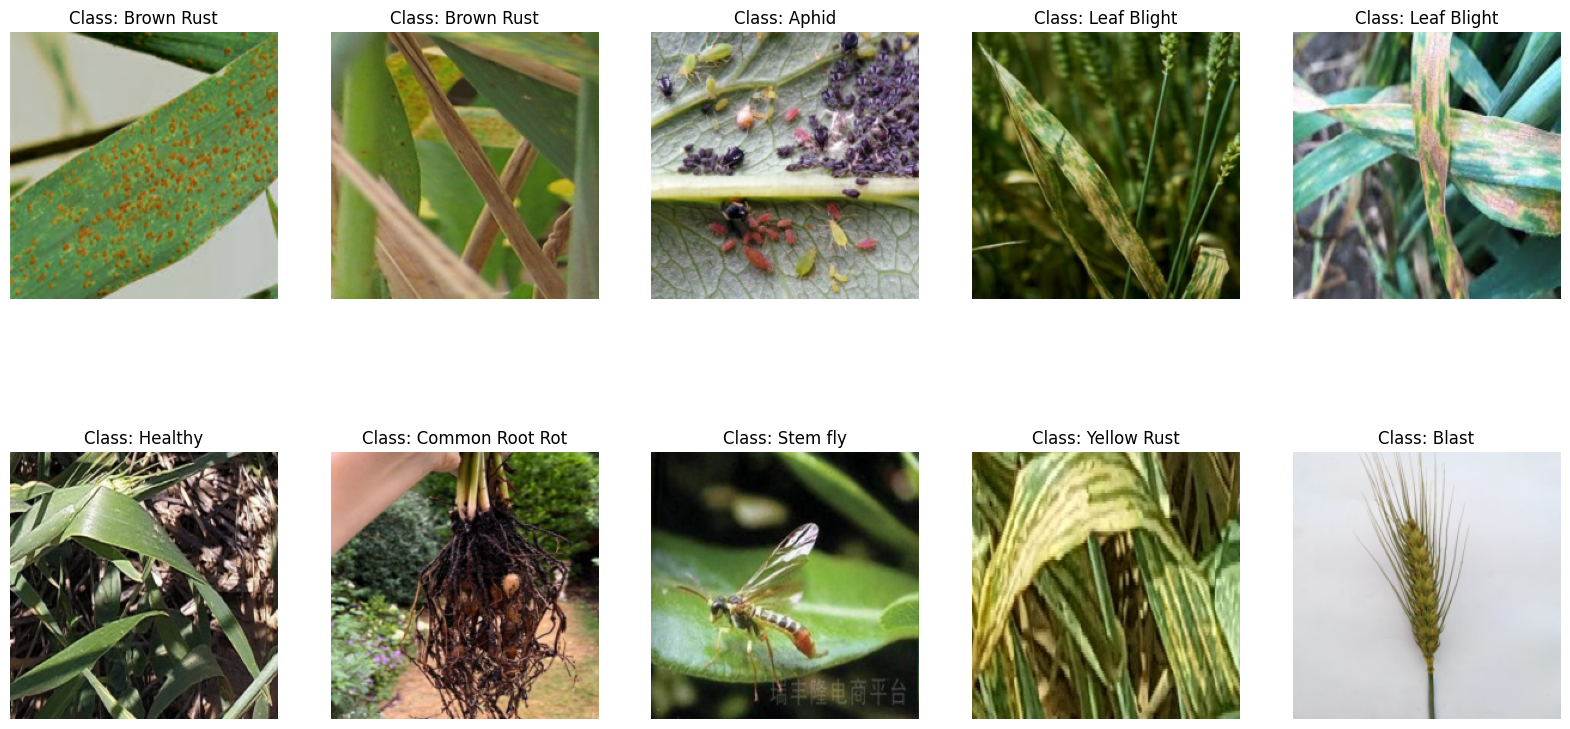

In [46]:
# plot 10 random images in the dataset
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    # Get a random image from the dataset
    index = np.random.randint(len(train_disease_dataset))
    image, label = train_disease_dataset[index]
    # Plot the image
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(f"Class: {class_names[label]}")
    ax.axis("off")
plt.show()

In [63]:
#Dropout_rate = 0.1
# Define the model
class Disease_classifier(nn.Module):
    def __init__(self, dropout_rate, batch_size, train_data, test_data, valid_data):
        super(Disease_classifier, self).__init__()
        # Define the dataloaders
        self.train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
        self.test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
        self.val_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
        # input shape: 3 * 224 * 224
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        # shape after conv1: 6 * 220 * 220
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # shape after pool: 6 * 110 * 110
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        # shape after conv2: 16 * 106 * 106
        self.fc1 = nn.Linear(in_features=44944, out_features=120)
        # shape after fc1: 120
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        # shape after fc2: 84
        self.fc3 = nn.Linear(in_features=84, out_features=15)
        # shape after fc3: 20 with batch size 32
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        #batch normalization layer
        self.batch_norm1 = nn.BatchNorm2d(6)
        self.batch_norm2 = nn.BatchNorm2d(16)
        self.softmax = nn.Softmax(dim=1)
        #explain batch normalization layer: https://towardsdatascience.com/batch-normalization-in-3-levels-of-understanding-14c2da90a338
    
    # Define the forward pass
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #batch normalization layer
        x = self.batch_norm1(x)
        x = self.pool(F.relu(self.conv2(x)))
        # batch normalization layer
        x = self.batch_norm2(x)
        x = x.view(-1, 16 * 53 * 53)
       # print(f"after view: {x.shape}")
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout1(x)
        x = self.fc3(x)
        x = self.dropout2(x)
       # print(f"after fc3: {x.shape}")
        x = self.softmax(x)
       # print(f"after log_softmax: {x.shape}")
        return x

### import helper functions


In [56]:
# Download helper functions from learn pytorch repo if not already downloaded
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


### Setup a loss function


In [57]:
# setup loss funtion
loss_fn = nn.CrossEntropyLoss()

In [58]:
#device
device = "cuda" if torch.cuda.is_available() else "cpu"

### Training loop

In [59]:

#define train loop function
def train_step(
        model: torch.nn.Module,
        loss_fn: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        accuracy_fn,
        device: torch.device = device):
    """Performs a training with model trying to learn on data_loader."""
    train_loss, train_acc = 0, 0

    # Put model into training mode
    model.train()

    #Add a loop through the training batches
    for batch, (X, y) in enumerate(model.train_dataloader):
        #Put data on target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass (outputs the raw logits from the model)
        train_pred = model(X)
        y_pred_probs = train_pred.softmax(dim=1)  # convert logits to probabilities

        # 2. Calculate loss and accuracy
        loss = loss_fn(train_pred, y)
        #train_loss += loss #accumulate train loss
        #train_acc += accuracy_fn(y_true=y,y_pred=y_pred_probs.argmax(dim=1)) #go from probabilities -> prediction labels
        #train_acc = train_acc / len(train_dataloader)

        # 2. Calculate the loss/acc
        train_loss += loss_fn(train_pred, y)
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred_probs.argmax(dim=1))  # go from logits -> prediction lables

        # Calculate accuracy manually
        #correct = (y_pred_probs.argmax(dim=1) == y).sum()
        #train_acc += correct.item() / len(y)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backward
        loss.backward()

        # 5. Optimizer step (update the model´s parameters once *per batch*)
        optimizer.step()

    # divide total train
    train_loss /= len(model.train_dataloader)
    train_acc /= len(model.train_dataloader)

    # Save the train accuracy and loss history
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss.item())
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

    return train_acc, train_loss  #, train_acc_history, train_loss_history


### Test loop

In [60]:

# define test loop function
def test_step(
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    data_loader: torch.utils.data.DataLoader,
    device:torch.device = device):
  """Performs a testing loop step on model going over data_loader."""
  test_loss, test_acc = 0,0 
  
  # Put the model in eval mode
  model.eval()
  
  
  # Turn on inference mode context manager
  with torch.inference_mode():
    for X, y in data_loader:
      #Send the data to the target device
      X,y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred = model(X)

      # 2. Calculate the loss/acc
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1)) # go from logits -> prediction lables
        
      
      
    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test_acc: {test_acc:.2f}%\n")
    
    # Save the test accuracy and loss history
    test_acc_history.append(test_acc)
    test_loss_history.append(test_loss.item()) 
        
    return test_acc, test_loss #, test_acc_history, test_loss_history


## Validation loop

In [61]:

# define val loop function
def val_step(
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    data_loader: torch.utils.data.DataLoader,
    device:torch.device = device):
  """Performs a testing loop step on model going over data_loader."""
  val_loss, val_acc = 0,0 
  
  # Put the model in eval mode
  model.eval()
  
  
  # Turn on inference mode context manager
  with torch.inference_mode():
    for X, y in data_loader:
      #Send the data to the target device
      X,y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred = model(X)

      # 2. Calculate the loss/acc
      val_loss += loss_fn(test_pred, y)
      val_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1)) # go from logits -> prediction lables
        
      
      
    # Adjust metrics and print out
    val_loss /= len(data_loader)
    val_acc /= len(data_loader)
    print(f"\nValidation loss: {val_loss:.5f} | Validation Accuracy: {val_acc:.2f}%\n")
    
   
        
    return val_acc, val_loss

In [64]:
# Placeholder for training history
train_loss_history = []
train_acc_history = []
# Placeholder for training history
test_loss_history = []
test_acc_history = []
#set manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)
# Hyperparameter Tuning with Optuna
def objective(trial):
    # Create the model with the suggested dropout rate
    model = Disease_classifier(dropout_rate=trial.suggest_float("dropout_rate", 0.1, 0.5),
                    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64]),
                    train_data = train_disease_dataset,
                    test_data = test_disease_dataset,
                    valid_data = valid_disease_dataset)
    
    #Learning rate and optimizer trials
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])
    
    # Create the optimizer with the suggested learning rate and optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr)
   
    
    #device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # Early stopping parameters
    patience = 5  # Number of epochs to wait before early stopping
    min_delta = 0.001  # Minimum change in validation loss to qualify as an improvement
    counter = 0
    best_loss = float('inf')
    # Training loop
    for epoch in range(3):  # Maximum number of epochs
            
        train_loss, train_acc = train_step(model, loss_fn, optimizer, accuracy_fn, device)
        test_acc, test_loss = test_step(model, loss_fn, accuracy_fn, model.test_dataloader, device)

        # Early stopping
        if test_loss < best_loss - min_delta:
            best_loss = test_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                raise TrialPruned()

        # Report intermediate values to Optuna
        trial.report(test_loss, epoch)

        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise TrialPruned()

    # Evaluate the model on the test set
    val_results = val_step(model, loss_fn, accuracy_fn, model.val_dataloader,  device)
    val_acc, val_loss = val_results
    return val_acc

# Execute the Study 
study = optuna.create_study(direction="maximize", study_name="hyperparameter_tuning_for_Disease_classification")
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2024-04-16 16:11:06,774] A new study created in memory with name: hyperparameter_tuning_for_Disease_classification


  0%|          | 0/100 [00:00<?, ?it/s]

[W 2024-04-16 16:12:29,557] Trial 0 failed with parameters: {'dropout_rate': 0.43691621125101154, 'batch_size': 64, 'lr': 2.0210956102245137e-05, 'optimizer': 'SGD'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/julianmagnago/.local/share/virtualenvs/WheatDiseaseClassifier-I6OUpnKR/lib/python3.11/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/2k/c3p8y0j913z7nh8832f5clzw0000gn/T/ipykernel_72738/39274851.py", line 40, in objective
    train_loss, train_acc = train_step(model, loss_fn, optimizer, accuracy_fn, device)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/2k/c3p8y0j913z7nh8832f5clzw0000gn/T/ipykernel_72738/3885316193.py", line 20, in train_step
    train_pred = model(X)
                 ^^^^^^^^
  File "/Users/julianmagnago/.local/share/virtualenvs/WheatDisea

KeyboardInterrupt: 

In [65]:
#Best Hyperparameters so far: {'dropout_rate': 0.2327112749924709, 'lr': 3.887789715877792e-05, 'batch_size': 16, 'optimizer': 'Adam'}
model_3 = Disease_classifier(dropout_rate=0.2327112749924709, batch_size=16, train_data=train_disease_dataset, test_data=test_disease_dataset, valid_data=valid_disease_dataset)
optimizer = optim.Adam(model_3.parameters(), lr=3.887789715877792e-05)
#set manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)
plotting = True
epochs=30
# Placeholder for training history
train_loss_history = []
train_acc_history = []
# Placeholder for training history
test_loss_history = []
test_acc_history = []

#train and test model including early stopping
for epoch in range(epochs):
  print(f"Epoch: {epoch}\n------")
  train_step(model=model_3,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_3,
            loss_fn = loss_fn,
            accuracy_fn = accuracy_fn,
            data_loader = model_3.test_dataloader,
            device = device)
# Evaluate the model on the test set
val_acc, val_loss = val_step(model_3, loss_fn, accuracy_fn, model_3.val_dataloader, device)
print(f"Validation results: {val_acc, val_loss}")

# Convert lists to NumPy arrays
train_loss_history = np.array(train_loss_history)
train_acc_history = np.array(train_acc_history)
test_loss_history = np.array(test_loss_history)
test_acc_history = np.array(test_acc_history)

if plotting == True:
    # Define the locations of the tick marks on the x-axis
    custom_ticks = [0, 5, 10, 15, 20, 25, 30]
    # Plot the training history
    plt.title('Training and Test Loss')
    plt.plot(train_loss_history, label='Training Loss', color='blue')
    plt.plot(test_loss_history, label='Test Loss', color='orange')
    plt.xlabel('Epoch')
    # Set the tick marks on the x-axis
    plt.xticks(custom_ticks)

    plt.ylabel('Loss')
    # in the range train_loss_history.min() to train_loss_history.max() AND test_loss_history.min() to test_loss_history.max()  
    plt.ylim(min(train_loss_history.min(), test_loss_history.min())-0.01, max(train_loss_history.max(), test_loss_history.max())+0.01)
    plt.xlim(0, epochs)
    plt.legend()
    plt.show()

    plt.title('Training and Test Accuracy')
    plt.plot(train_acc_history, label='Training Accuracy', color='blue')
    plt.plot(test_acc_history, label='Test Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    # Set the tick marks on the x-axis
    plt.xticks(custom_ticks)

    plt.xlim(0, epochs)
    plt.legend()
    plt.show()
  

Epoch: 0
------


KeyboardInterrupt: 